## Importando as Bibliotecas necessarias

In [1]:
import pandas as pd
import numpy as np
from summarytools import dfSummary
from scipy import stats
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Extraindo os Dados

In [2]:
df = pd.read_excel('/content/PEDIDO-_1__.xlsx')
df2 = pd.read_excel('/content/ITEM_PEDIDO-_2_ _.xlsx')
df3 = pd.read_excel('/content/ITENS-_3___.xlsx')

In [3]:
df = df.drop(columns=['Unnamed: 0'])
df['DATA'] = pd.to_datetime(df['DATA'])

In [4]:
df2 = df2.drop(columns=['Unnamed: 0'])

In [5]:
df3.columns = ['ID_ITEM', 'Valor_Item']

In [6]:
df_merged = pd.merge(pd.merge(df, df2, on='ID_PEDIDO', how='inner'), df3, on='ID_ITEM', how='left')

df_merged['VALOR_TOTAL'] = df_merged['QUANTIDADE'] * df_merged['Valor_Item']

new_column_order = ['ID_PEDIDO', 'DATA', 'ID_ITEM', 'QUANTIDADE', 'Valor_Item', 'VALOR_TOTAL']
df_merged = df_merged[new_column_order]

df_merged.head()

,ID_PEDIDO,DATA,ID_ITEM,QUANTIDADE,Valor_Item,VALOR_TOTAL
0,120210601,2021-06-01,item C,4,20,80
1,220210601,2021-06-01,item A,3,10,30
2,320210604,2021-06-04,item C,1,20,20
3,420210604,2021-06-04,item B,4,15,60
4,420210604,2021-06-04,item C,2,20,40


In [7]:
dfSummary(df_merged)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID_PEDIDO[int64],Mean (sd) : 7675464960.0 (4263868747.9)min < med < max:120210601.0 < 7920210718.0 < 14720210901.0IQR (CV) : 7050000180.5 (1.8),181 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACtElEQVR4nO3dT4riQBSA8Vdjq/EPEXHQnRcYmIVLDzGHnSO04Am8gTshSMRMB2PMrHoY6LbVlGXyyu+3leoW+ap86QTaFEUhQN19q/oNANd4qfoNwB/GmI6ItEouPxRF8XbuRULFXRhjOqPR6FcYhsMy63e73dYY8/tcrN6Garm7RS7scHzQCsNwOJ/P3waDQXrLwjiOg+VyOYyiqCUizxOq7e4WubzD8bnBYJCOx+M/JZZ2vnrRy1DFYneLXLfD8Vi+hioiVrtb5MIOx2Px5ymoQKhQgVChAqFCBUKFCl5f9T8jl7cxq0SoHnF9G7NKF0P1dYfWleXnHfb7/fF8Pt+5uI1ZpS9D9XmH1pHt551lWZDn+Y92u/3q4jZmlS6dqE4fNPCVxalY+kQUEVmv18PVatU9Ho+NEr+71q6aUV09aOAjm1PR9kTcbrfeft5cTN1f6W8hn09EW4TqSJlvoapPxDzPmyISGmPKLA9Pp1Pzzm/pH0KFiIgkSdLMsuzndDptNBqNm+fj97ElTdNXESn7xNpZhHqGxeni9GRx5XA4vARB0J3NZulkMtneut712EKon7A5XVyfLK71er1SF86uxxanoVrOPCIV3TCwOV24IHLDWai2M49I9TcMypwuVV8Q+cpZqLYzTxzHwWKxGEdR9N0Ys7txuco5Eec5n1HLzjzPPCfio9peTDEn4n+1DfUdcyJEeMIfShAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKV/2fqTiOg1t/8H6/D0REkiQJNptN95Hrtf5ure/bdv01ff0FPQWf2TeT1ZwAAAAASUVORK5CYII="">",0(0.0%)
2,DATA[datetime64[ns]],Min: 2021-06-01Max: 2021-09-01Duration: 92 days,81 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACuElEQVR4nO3csW7aUBiG4f9AiEwS2UJpYWPpWKkDYy6iF9tLaKRcQYYundiQEDLCDcKx6ZJuheQc7A9sv89+oiP0ysf2b8Xt93sDFHrn3gC6g9ggc3XuDTSVc25oZtcBS3f7/f6l6v00AbEFcM4N7+/vv8dxPPJdu16vV865H10MjtjCXMdxPHp4eHhJkmT70UVpmkZPT0+j5XJ5bWbEho9LkmQ7Ho//eC4b1rKZBuABATLEBhligwyxQYbYIENskCE2yBAbZIgNMp2eIJwwTI/LshxUvZ+262xspwzT8zyPiqL4ut1uf5qZ77iqszobmwUO083M5vP56Pn5+eb19bVf1+ba6KJiO+FY65lZ6bkmLstykCTJyneYvlqt5MN08W9jVsN3dxcTW+ixVhTFIMuyL3d3d797vV7+0XVNOgrVv41ZPd/dXUxsFnisvR1pn2ez2a/JZLLyXNeUo1D626RpGj0+Po6Xy+Un59zac68Hr4iXFJuZ+X8j9u9Iu729DVrXJKrfJsuyQZ7n36bTab/f73vdzx67Il5cbDi/3W53FUXRzWw22/peEY99iUxsOMj3ivjm4InBBAEyxAYZYoMMsUGG2CBTy9No4GiFLylarvLYQkcrTRofIUwdV7ZTRitNGR8hQG0vdUNHK2gvJghiRVEMzCx2zvksa8X9LLEJhQ6423I/S2xCoQPuttzPEtsZdOFzqP/hpS5kjl7ZeDmLKh2MjZezqNqxKxsvZ1Gpdx8QeDmLqvCAABligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGmXf/82SappHPH9xsNpGZWZZl0WKxuGnbuibtVb3uvVb+ArLnigToe2fEAAAAAElFTkSuQmCC"">",0(0.0%)
3,ID_ITEM[object],1. item D2. item B3. item C4. item A,83 (28.1%)73 (24.7%)72 (24.4%)67 (22.7%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB3ElEQVR4nO3bQWrbYBSF0aciQjKRMAYvxovIYrsI7cYYa9CETNRBp4HYJb36pZ6zgjf4kJHR7ZZlKUj4sfYB/D/ERkxXVS9V9bT2IQ/4WJblbe0jeFx/PB5fh2E4rH3IveZ5vnZd91Nw29MPw3A4n89v4zi+r33MV2632/M0TYfL5fJUVWLbmL6qahzH99Pp9GvtY+70svYB/B0vCMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/159OdtQ+5x1bu5HP9PM/XaZoOtZFPd+Z5vlbVx9p38DifhRPTmfKR4gWBmJZ/Rv1c7kyz6yorqv1pcl1lRbVPLa+rNvFXDPfzgkCM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNmCanfK3dw/dodspnsrc/NgjEmPIR48lGjHUVMdZVxFhXEeNPXWLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEWFcRY11FjA0CMdZVxLT2ZPM027Gm1lUWVfvWzLrKomr/WltXNfVGzPfypy4xYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YppZV7VwA/9WU+sqi6p9s0EgxrqKGC8IxPwGs1jYuZLsWQAAAAAASUVORK5CYII="">",0(0.0%)
4,QUANTIDADE[int64],1. 42. 13. 54. 35. 2,67 (22.7%)60 (20.3%)58 (19.7%)57 (19.3%)53 (18.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACIklEQVR4nO3bwWkbQQCG0VEQJrlICIGLcREpNkWoG2O0h9j4ohycFvyN0LxXwRw

Valores nulos e duplicados, tipos de dados, entre outros processos já foram tratados no notebook 'EDA_Mr_Health.ipynb'.
Iremos realizar daqui para frente, um refinamento com propósitos de modelagem, afinal, a limpeza inicial foi feita direcionada à análise exploratória de dados.

## Definindo as variaveis numericas.

As variáveis numéricas são a chave para desvendar os segredos dos dados.

Ao analisá-las, poderemos identificar padrões, tendências e insights valiosos que nos auxiliarão na tomada de decisões mais assertivas.

In [8]:
features_numericas = df_merged.select_dtypes('number').columns.tolist()
categorical_features = df_merged.select_dtypes(['category', 'object']).columns.to_list()

print(f'Contem {len(features_numericas)} características numéricas. Eles são: ')
print(features_numericas)
print(f'Há {len(categorical_features)} variáveis categóricas. São elas: {categorical_features}')
print(categorical_features)

Contem 4 características numéricas. Eles são: 
['ID_PEDIDO', 'QUANTIDADE', 'Valor_Item', 'VALOR_TOTAL']
Há 1 variáveis categóricas. São elas: ['ID_ITEM']
['ID_ITEM']


In [9]:
print('Cardinalidade das variáveis categóricas: ')
for feature in categorical_features:
    print(f'{feature} ({df_merged[feature].nunique()})', end=', ')

Cardinalidade das variáveis categóricas: 
ID_ITEM (4), 

## Split dos dados em sets de treino, teste e validação

1. Os dados de teste são dados que o modelo nunca viu. Por isso, irei realizar o split antes de qualquer coisa. O teste será isolado e utilizado apenas no final para avaliar uma vez o melhor modelo escolhido. Isso garantirá uma avaliação de performance confiável, simulando um ambiente real de produção. Ademais, data leakage também é evitado, aplicando apenas 'transform' neste conjunto.
2. Os dados de validação serão utilizados na tunagem de hiperparâmetros para avaliar o modelo treinado em cada configuração. Isso nos ajuda a prevenir o overfitting, evitando decisões baseadas em ajuste excessivo ao conjunto de treinamento.

In [10]:
one_hot = pd.get_dummies(df_merged['ID_ITEM'])

df_one_hot = pd.concat([df_merged, one_hot], axis=1)

df_one_hot.head()

,ID_PEDIDO,DATA,ID_ITEM,QUANTIDADE,Valor_Item,VALOR_TOTAL,item A,item B,item C,item D
0,120210601,2021-06-01,item C,4,20,80,False,False,True,False
1,220210601,2021-06-01,item A,3,10,30,True,False,False,False
2,320210604,2021-06-04,item C,1,20,20,False,False,True,False
3,420210604,2021-06-04,item B,4,15,60,False,True,False,False
4,420210604,2021-06-04,item C,2,20,40,False,False,True,False


In [11]:
df_one_hot.columns

Index(['ID_PEDIDO', 'DATA', 'ID_ITEM', 'QUANTIDADE', 'Valor_Item',
       'VALOR_TOTAL', 'item A', 'item B', 'item C', 'item D'],
      dtype='object')

In [12]:
df_one_hot.head()

,ID_PEDIDO,DATA,ID_ITEM,QUANTIDADE,Valor_Item,VALOR_TOTAL,item A,item B,item C,item D
0,120210601,2021-06-01,item C,4,20,80,False,False,True,False
1,220210601,2021-06-01,item A,3,10,30,True,False,False,False
2,320210604,2021-06-04,item C,1,20,20,False,False,True,False
3,420210604,2021-06-04,item B,4,15,60,False,True,False,False
4,420210604,2021-06-04,item C,2,20,40,False,False,True,False


In [13]:
df_one_hot['Year'] = df_one_hot['DATA'].dt.year
df_one_hot['Month'] = df_one_hot['DATA'].dt.month

# Selecionar as colunas para X e y
X = df_one_hot[['QUANTIDADE',
                'Year',
                'Month',
                'Valor_Item',
                'item A',
                'item B',
                'item C',
                'item D']]
y = df_one_hot['VALOR_TOTAL']


In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train predictor set shape: {X_train.shape}. Train target set shape: {y_train.shape}')
print(f'Test predictor set shape: {X_test.shape}. Test target set shape: {y_test.shape}')
print(f'Validation predictor set shape: {X_val.shape}. Validation target set shape: {y_val.shape}')

Train predictor set shape: (236, 8). Train target set shape: (236,)
Test predictor set shape: (29, 8). Test target set shape: (29,)
Validation predictor set shape: (30, 8). Validation target set shape: (30,)


### Criando modelos que serão testados para definir qual o melhor.

Iremos usar cinco (5) modelos diferentes para ver como eles se saem com os dados e predizendo os resultados, para que possamos usar o melhor modelo.
Sendo eles XGBoost, LightGBM, CatBoost, DecisionTree e AdaBoost.

In [15]:
modelo_XGBoost = XGBRegressor(n_estimators = 1000, max_depth = 8, learning_rate = 1e-3, n_jobs = -1, random_state = 0)
modelo_LightGBM = LGBMRegressor(n_estimators = 1000, max_depth = 8, num_leaves = 2^8, learning_rate = 1e-3, n_jobs = -1, verbose = -1, random_state = 0)
modelo_catboost = CatBoostRegressor(n_estimators = 1000, max_depth = 8, learning_rate = 1e-3, random_state = 0, verbose = 0)
modelo_decision_tree = DecisionTreeRegressor(random_state = 0, max_depth = 8, min_samples_split = 2)
modelo_adaboost = AdaBoostRegressor(n_estimators=100, base_estimator=DecisionTreeRegressor(max_depth=2))

### XGBoost

In [16]:
modelo_XGBoost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=0, ...)

### LGBMRegressor

In [17]:
modelo_LightGBM.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.001, max_depth=8, n_estimators=1000, n_jobs=-1,
              num_leaves=10, random_state=0, verbose=-1)

### CatBoost

In [18]:
modelo_catboost.fit(X_train, y_train)

### DecisionTree

In [19]:
modelo_decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, random_state=0)

### AdaBoost

In [20]:
modelo_adaboost.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=2),
                  n_estimators=100)

### Avaliando modelos

In [21]:
# Fazer previsões
y_pred_XGBoost = modelo_XGBoost.predict(X_test)
y_pred_LightGBM = modelo_LightGBM.predict(X_test)
y_pred_CatBoost = modelo_catboost.predict(X_test)
y_pred_DecisionTree = modelo_decision_tree.predict(X_test)
y_pred_AdaBoost = modelo_adaboost.predict(X_test)

# Avaliar os modelos
mse_XGBoost = mean_squared_error(y_test, y_pred_XGBoost)
rmse_XGBoost = mean_absolute_error(y_test, y_pred_XGBoost)
r2_XGBoost = r2_score(y_test, y_pred_XGBoost)

mse_LightGBM = mean_squared_error(y_test, y_pred_LightGBM)
rmse_LightGBM = mean_absolute_error(y_test, y_pred_LightGBM)
r2_LightGBM = r2_score(y_test, y_pred_LightGBM)

mse_CatBoost = mean_squared_error(y_test, y_pred_CatBoost)
rmse_CatBoost = mean_absolute_error(y_test, y_pred_CatBoost)
r2_CatBoost = r2_score(y_test, y_pred_CatBoost)

mse_DecisionTree = mean_squared_error(y_test, y_pred_DecisionTree)
rmse_DecisionTree = mean_absolute_error(y_test, y_pred_DecisionTree)
r2_DecisionTree = r2_score(y_test, y_pred_DecisionTree)

mse_AdaBoost = mean_squared_error(y_test, y_pred_AdaBoost)
rmse_AdaBoost = mean_absolute_error(y_test, y_pred_AdaBoost)
r2_AdaBoost = r2_score(y_test, y_pred_AdaBoost)

# Exibir os resultados
print("XGBoost:")
print(f'Mean Squared Error: {mse_XGBoost}')
print(f"RMSE: {rmse_XGBoost}\n")
print(f'R-squared: {r2_XGBoost}\n')

print("LightGBM:")
print(f'Mean Squared Error: {mse_LightGBM}')
print(f"RMSE: {rmse_LightGBM}\n")
print(f'R-squared: {r2_LightGBM}\n')

print("CatBoost:")
print(f'Mean Squared Error: {mse_CatBoost}')
print(f"RMSE: {rmse_CatBoost}\n")
print(f'R-squared: {r2_CatBoost}\n')

print("Decision Tree:")
print(f'Mean Squared Error: {mse_DecisionTree}')
print(f"RMSE: {rmse_DecisionTree}\n")
print(f'R-squared: {r2_DecisionTree}\n')

print("AdaBoost:")
print(f'Mean Squared Error: {mse_AdaBoost}')
print(f"RMSE: {rmse_AdaBoost}\n")
print(f'R-squared: {r2_AdaBoost}')

XGBoost:
Mean Squared Error: 167.76581035250888
RMSE: 10.385634915582065

R-squared: 0.8277486918490295

LightGBM:
Mean Squared Error: 191.04383009350255
RMSE: 11.04953239873479

R-squared: 0.8038482955577639

CatBoost:
Mean Squared Error: 246.93060339038846
RMSE: 12.330941675295488

R-squared: 0.7464672964823384

Decision Tree:
Mean Squared Error: 0.0
RMSE: 0.0

R-squared: 1.0

AdaBoost:
Mean Squared Error: 139.3801160189824
RMSE: 9.391898677006479

R-squared: 0.856893324902986


*    XGBoost se destaca: Com o menor MSE (167.77) e RMSE (10.39), o XGBoost apresenta o melhor desempenho em termos de precisão de previsão.
*    AdaBoost surpreende, apesar de não ser o modelo com o menor erro médio, o AdaBoost obteve um MSE (139.38) e RMSE (9.39) bem próximos do XGBoost, indicando uma performance surpreendentemente boa.
*    LightGBM e CatBoost apresentam desempenho mediano, embora LightGBM (MSE: 191.04, RMSE: 11.05) e CatBoost (MSE: 246.93, RMSE: 12.33) tenham ficado atrás do XGBoost, eles ainda apresentam resultados razoáveis.
*    Árvore de Decisão é suspeita o modelo de Árvore de Decisão obteve MSE e RMSE iguais a zero, o que é improvável. Provavelmente ocorreu overfitting, onde o modelo se adapta demais aos dados de treino e não generaliza bem para dados novos.

### Visualizar as previsões

### Previsões XGBoost

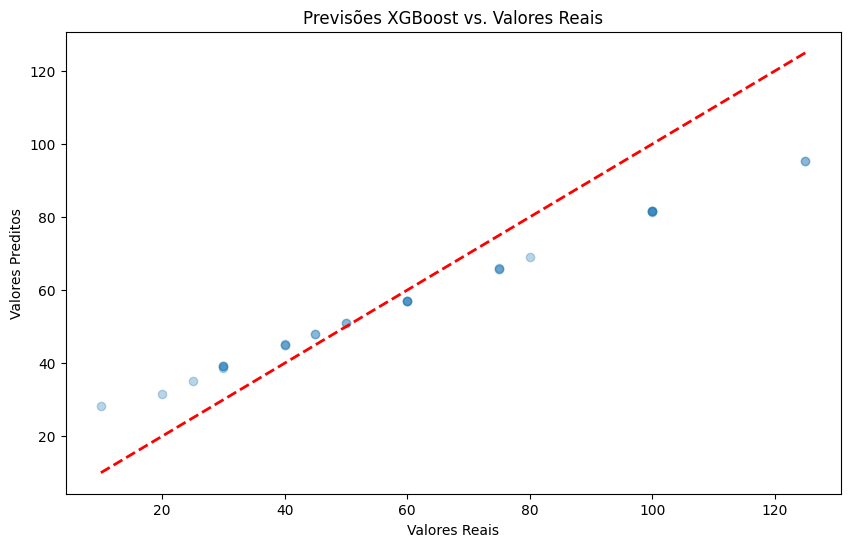

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_XGBoost, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Previsões XGBoost vs. Valores Reais')
plt.show()

### Previsões LightGBM

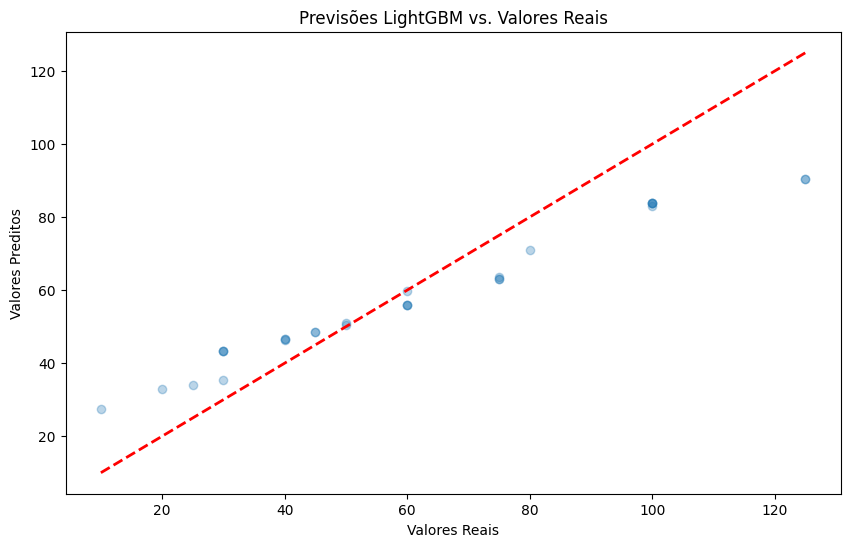

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_LightGBM, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Previsões LightGBM vs. Valores Reais')
plt.show()

### Previsões CatBoost

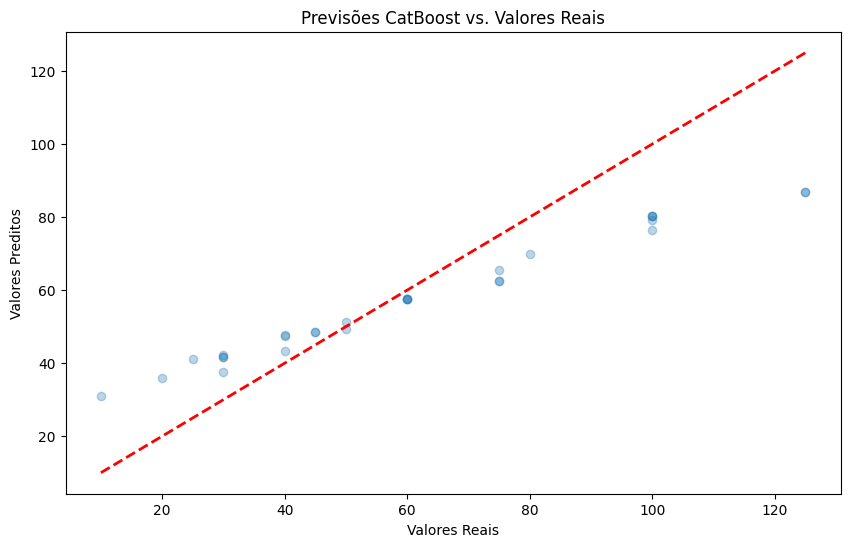

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_CatBoost, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Previsões CatBoost vs. Valores Reais')
plt.show()

### Previsões DecisionTree

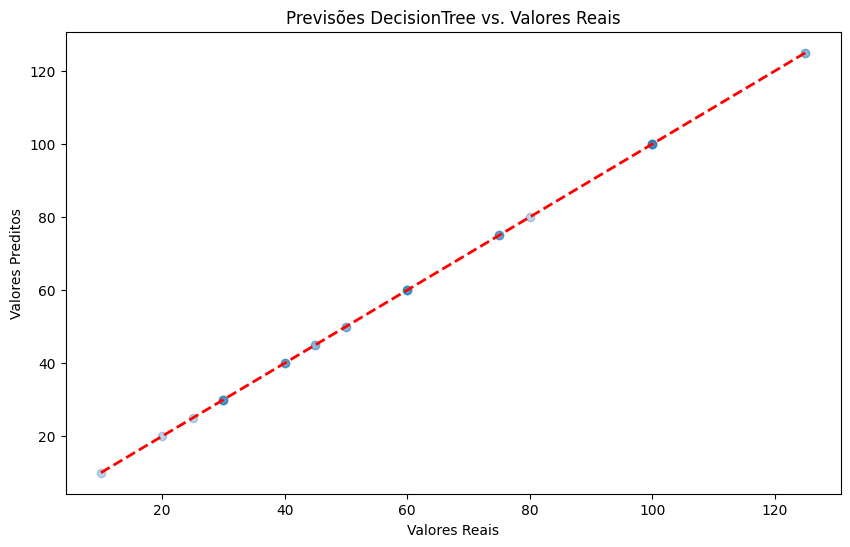

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_DecisionTree, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Previsões DecisionTree vs. Valores Reais')
plt.show()

### AdaBoost

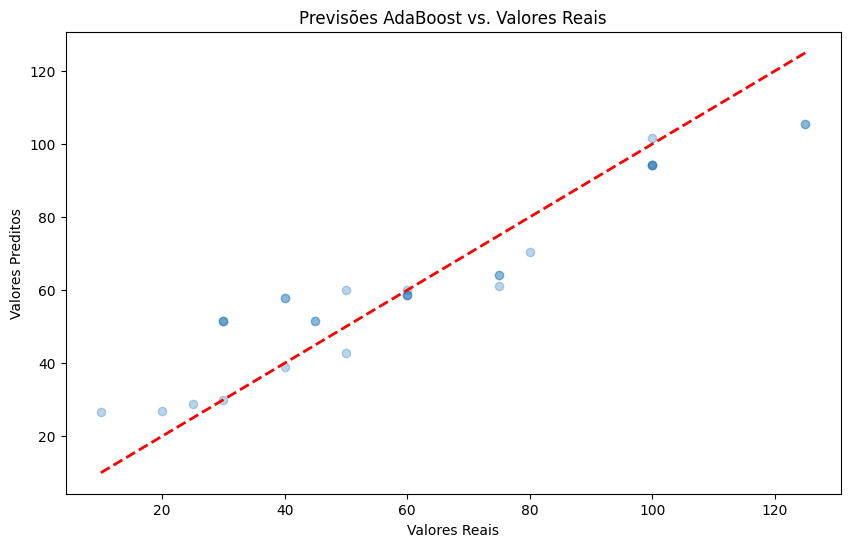

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_AdaBoost, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Previsões AdaBoost vs. Valores Reais')
plt.show()

# Análise dos resultados de regressão

Analisando os resultados de regressão fornecidos, podemos observar alguns pontos interessantes:

1. Erro Médio Quadrático (MSE) e Root Mean Squared Error (RMSE):

    *    XGBoost apresentou o menor MSE (167.77) e RMSE (10.39), indicando o melhor desempenho em termos de precisão de previsão.
    *    LightGBM seguiu de perto, com valores um pouco maiores de MSE (191.04) e RMSE (11.05).
    *    CatBoost e AdaBoost tiveram desempenho inferior, com MSE e RMSE maiores.
    *    O modelo de Árvore de Decisão obteve MSE e RMSE iguais a zero, o que parece suspeito. É provável que tenha ocorrido overfitting, onde o modelo se adapta demais aos dados de treino e não generaliza bem para dados novos.

2. R-quadrado (R²):

    *    XGBoost novamente se destaca com o maior R² (0.8277), indicando que explica 82.77% da variância da variável resposta.
    *    LightGBM também obteve um R² alto (0.8038).
    *    CatBoost e AdaBoost apresentaram R² menores, indicando menor poder explicativo.
    *    O alto R² da Árvore de Decisão corrobora o overfitting, pois o modelo se ajusta demais aos dados de treino, capturando até mesmo ruído, o que inflaciona o R².


3. Resumo:

    *    XGBoost apresenta o melhor desempenho geral, com um bom equilíbrio entre baixa MSE e alta R².

    *    LightGBM também tem um bom desempenho, ligeiramente inferior ao XGBoost.

    *    CatBoost é razoável, mas menos preciso que os outros dois.

    *    Decision Tree mostra sinais de overfitting, não sendo ideal para generalização em novos dados.

Para escolher um modelo para produção, XGBoost seria a melhor escolha devido ao seu desempenho equilibrado e robustez.



## Entendendo melhor as métricas de Avaliação em Regressão.



1. Erro Médio Quadrático (MSE): A Soma dos Quadrados dos Erros

    *    O MSE, como o próprio nome sugere, calcula a média da soma dos quadrados dos erros entre os valores previstos pelo modelo e os valores reais observados. Imagine que você tem diversas previsões e seus erros respectivos. O MSE pega esses erros, eleva cada um ao quadrado, soma todos eles e divide essa soma pela quantidade de erros.

    *   Mas por que elevar ao quadrado?

    *    Dando mais peso a erros maiores ao elevar ao quadrado, erros maiores se tornam mais "penalizados" do que erros menores. Isso é importante porque, em muitos casos, erramos por pouco é aceitável, mas errar muito pode ter consequências sérias. O MSE garante que esses erros grandes não sejam ignorados.


2. R-quadrado (R²): Explicando a Variância

    *    O R², por outro lado, vai além da simples avaliação do erro. Ele busca entender qual porcentagem da variância da variável resposta (aquela que queremos prever) é explicada pelo modelo. Em outras palavras, o R² nos diz o quão bem o modelo consegue "justificar" a variação observada nos dados.

    *    Valores do R² e suas interpretações:

    *    R² = 0: O modelo não explica nada da variância da variável resposta. É como se ele fosse aleatório.

    *    0 < R² < 1: O modelo explica alguma parte da variância, mas nem tudo. Quanto maior o R², melhor o modelo.

    *     R² = 1: O modelo explica 100% da variância da variável resposta. Isso é perfeito, mas não realista.



3. Root Mean Squared Error (RMSE)

   *    O RMSE, como o nome sugere, é a raiz quadrada do MSE. Ele dá a média dos erros em sua unidade original. Isso facilita a interpretação do erro, pois nos coloca na mesma escala das variáveis do problema.

# Conclusão

Insights:

1. Neste notebook, foram desenvolvido varaios modelos preditivos para predição de controle de estoque.
2. O modelo escolhido como o melhor performance para prever o controle de estoque foi o modelo XGBoost.
3. Foram consideradas diversas variáveis na construção do modelo. Os insights obtidos na etapa de análise exploratória de dados serviram de guia para a tarefa de pré-processamento de dados, necessária para a aplicação de algoritmos de machine learning.
4. O resultado obtido foi satisfatório, porém há espaço para melhorias:
    *    XGBoost apresentou o menor MSE (167.77) e RMSE (10.39), indicando o melhor desempenho em termos de precisão de previsão.
    *    XGBoost se destaca com o maior R² (0.8277), indicando que explica 82.77% da variância da variável resposta.